In [1]:
from mongodbcredentials import CONNECTION_STRING
from pymongo import MongoClient
import certifi
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
client = MongoClient(CONNECTION_STRING, tlsCAFile=certifi.where())

In [31]:
twitter_facemasks = client.TwitterFacemasks
twitter_lockdown = client.TwitterLockdown
twitter_pcr = client.TwitterPCR
twitter_pfizer = client.TwitterPfizer
twitter_quarantine = client.TwitterQuarantine
twitter_restrictions = client.TwitterRestrictions
twitter_vaccine = client.TwitterVaccination

In [32]:
def get_mostcommon_posts(db):
    top_tweets = db.SocialMediaPosts.aggregate([
        { "$group": { "_id": "$tweet", "count": { "$sum": 1 }}}, 
        { "$sort": { "_id.tweet":1, "count": -1 }  },
    ])
    top_tweets = save_results(top_tweets)
    return top_tweets[:10]

In [28]:
def save_results(data):
    results = []
    for result in data:
        dictionary = {}
        dictionary['tweet'] = result['_id']
        dictionary['count'] = result['count']
        results += [dictionary]

    return results

In [35]:
analyzer = SentimentIntensityAnalyzer()

In [36]:
def database_as_dictionary(db):
    list_of_dicts = []

    for entry in db.SocialMediaPosts.find():
        empty = {}
        empty['tweet'] = entry['tweet']

        vs = analyzer.polarity_scores(entry['tweet'])
        compound = vs['compound']
  
        if (compound >= 0.05):
            empty['sentiment'] = 'positive'

        elif (compound <= -0.05):
            empty['sentiment'] = 'negative'

        else:
            empty['sentiment'] = 'neutral'

        list_of_dicts += [empty]
    return list_of_dicts

In [38]:
facemasks_dict = database_as_dictionary(twitter_facemasks)
lockdown_dict = database_as_dictionary(twitter_lockdown)
pcr_dict = database_as_dictionary(twitter_pcr)
pfizer_dict = database_as_dictionary(twitter_pfizer)
quarantine_dict = database_as_dictionary(twitter_quarantine)
restrictions_dict = database_as_dictionary(twitter_restrictions)
vaccine_dict = database_as_dictionary(twitter_vaccine)

In [39]:
def pos_neg_count(dictionary):
    total_sentiment = {}
    total_sentiment['positive'] = 0
    total_sentiment['negative'] = 0
    total_sentiment['neutral'] = 0

    for post in dictionary:
     
        if post['sentiment'] == 'positive':
            total_sentiment['positive'] += 1

        elif post['sentiment'] == 'negative':
            total_sentiment['negative'] += 1

        else:
            total_sentiment['neutral'] += 1
    
    return total_sentiment

In [40]:
facemasks_sentiment = pos_neg_count(facemasks_dict)
lockdown_sentiment = pos_neg_count(lockdown_dict)
pcr_sentiment = pos_neg_count(pcr_dict)
pfizer_sentiment = pos_neg_count(pfizer_dict)
quarantine_sentiment = pos_neg_count(quarantine_dict)
restrictions_sentiment = pos_neg_count(restrictions_dict)
vaccine_sentiment = pos_neg_count(vaccine_dict)

In [49]:
import matplotlib.pyplot as plt
import numpy as np

In [48]:
list_of_topics = ['Facemasks', 'Lockdown', 'PCR', 'Pfizer', 'Quarantine', 'Restrictions', 'Vaccine']

In [53]:
def plot_topics(list_of_topics, data_points):
    fig = plt.figure()
    x_point = np.arange(7)
    fig = plt.figure(figsize=(18, 10))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(x_point + 0.00, data_points[0], color = 'g', width = 0.25)
    ax.bar(x_point + 0.25, data_points[1], color = 'r', width = 0.25)
    ax.bar(x_point + 0.50, data_points[2], color = 'b', width = 0.25)
    ax.set_ylabel('Number of posts', fontweight='bold', fontsize=16)
    ax.set_xlabel('Search query', fontweight='bold', fontsize=16)
    ax.set_title("Sentiment amongst Twitter queries", fontweight='bold', fontsize=20)
    plt.xticks(x_point + 0.25, list_of_topics)

    ax.legend(labels=['Positive', 'Negative', 'Neutral'])

In [54]:
query_dpts = []
positive = []
negative = []
neutral = []

for sentiment in facemasks_sentiment, lockdown_sentiment, pcr_sentiment, \
    pfizer_sentiment, quarantine_sentiment, restrictions_sentiment, vaccine_sentiment:
    positive += [sentiment['positive']]
    negative += [sentiment['negative']]
    neutral += [sentiment['neutral']]

query_dpts += [positive, negative, neutral]

<Figure size 432x288 with 0 Axes>

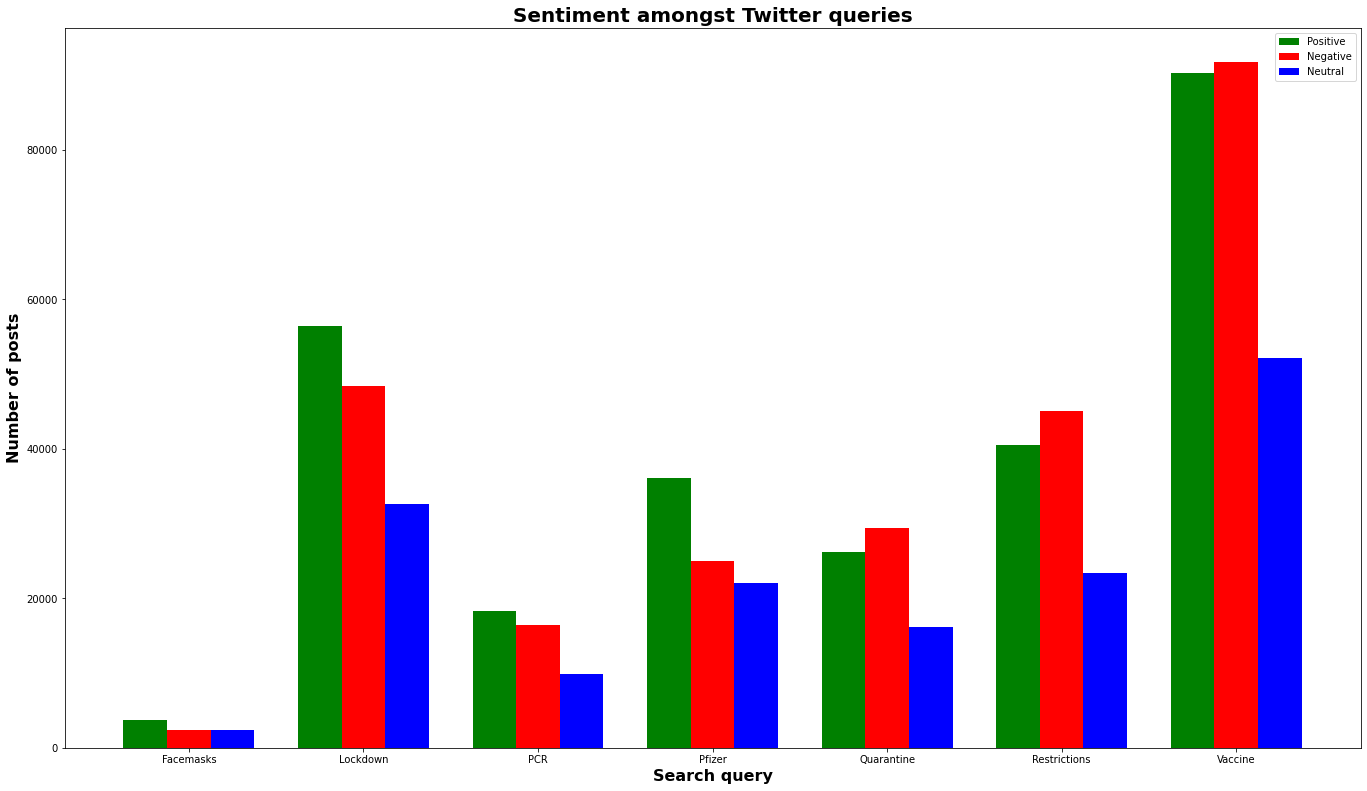

In [55]:
plot_topics(list_of_topics, query_dpts)